In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from DeepPurpose.pybiomed_helper import _GetPseudoAAC, CalculateAADipeptideComposition, \
calcPubChemFingerAll, CalculateConjointTriad, GetQuasiSequenceOrder
import torch
from torch.utils import data
from torch.autograd import Variable
try:
	from descriptastorus.descriptors import rdDescriptors, rdNormalizedDescriptors
except:
	raise ImportError("Please install pip install git+https://github.com/bp-kelley/descriptastorus.")
from DeepPurpose.chemutils import get_mol, atom_features, bond_features, MAX_NB, ATOM_FDIM, BOND_FDIM
from subword_nmt.apply_bpe import BPE
import codecs
import pickle
import wget
from zipfile import ZipFile 
import os
import sys

from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import SequentialSampler
from torch import nn 

from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
from sklearn.metrics import mean_squared_error, roc_auc_score, average_precision_score, f1_score, log_loss
from lifelines.utils import concordance_index
from scipy.stats import pearsonr
import pickle 
torch.manual_seed(2)
np.random.seed(3)
import copy
from prettytable import PrettyTable

import os

from DeepPurpose.utils import *
from DeepPurpose.model_helper import Encoder_MultipleLayers, Embeddings        
from DeepPurpose.encoders import *
from DeepPurpose import DTI

In [2]:
df = pd.read_pickle("./df.pkl")

In [3]:
idx_str = ['IC50','Temp']
df_want = df

# have at least uniprot or pubchem ID
df_want = df_want[df_want.PubChem_ID.notnull() | df_want.UniProt_ID.notnull()]
df_want = df_want[df_want.InChI.notnull()]
df_want = df_want[df_want['Temp'].notnull()]
df_want = df_want[df_want['pH'].notnull()]
df_want = df_want[df_want['IC50'].notnull()]

for label in idx_str:
#    print(df_want.size)
    df_want[label] = df_want[label].str.replace('>', '')
    df_want[label] = df_want[label].str.replace('<', '')
    #df_want[label] = df_want[label].astype(float)
#    df_want = df_want[df_want[label] <= 10000000.0]

y = df_want[idx_str]
for label in idx_str:
    y[label] = df_want[label].values

y['pH'] = df_want['pH']
y['pIC50'] = -np.log10(y['IC50'].astype(np.float32)*1e-9 + 1e-10)
X_drugs = df_want.SMILES.values
X_targets = df_want['Target Sequence'].values
X_org = df_want['Organism']
y = y.apply(pd.to_numeric, errors='coerce')
df_data = y
df_data['SMILES'] = X_drugs
df_data['Target Sequence'] = X_targets
df_data['Organism'] = X_org

print('in total: ' + str(len(df_data)) + ' drug-target pairs')
df_data

in total: 93309 drug-target pairs


C:\Users\Julia\anaconda3\envs\multiPurpose\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Julia\anaconda3\envs\multiPurpose\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,IC50,Temp,pH,SMILES,Target Sequence,Organism
180,8.5,37.0,6.0,CC(C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1ccccc1)[C@@...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,Human immunodeficiency virus 1
181,177.0,37.0,6.0,CCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1)[...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,Human immunodeficiency virus 1
183,164.0,37.0,6.0,COCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,Human immunodeficiency virus 1
184,67.0,37.0,6.0,COCCOCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccc...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,Human immunodeficiency virus 1
185,27.0,37.0,6.0,COC(=O)N[C@@H](C(C)C)C(=O)NN(C[C@H](O)[C@H](Cc...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,Human immunodeficiency virus 1
...,...,...,...,...,...,...
1062791,29.5,22.0,7.5,CN(CCCCCCn1c(O)c2Cc3ccccc3Cn2c1=O)CCc1ccccc1,MQWAVGRRWAWAALLLAVAAVLTQVVWLWLGTQSFVFQREEIAQLA...,Homo sapiens
1751877,8.9,25.0,2.5,CCC1OC(=O)C(C)C(O[C@H]2C[C@@](C)(OC)[C@@H](O)C...,MGSPWNGSDGPEDAREPPWAALPPCDERRCSPFPLGTLVPVTAVCL...,NaN
1751879,71.0,25.0,2.5,CCC1OC(=O)C(C)C(O[C@H]2C[C@@](C)(OC)[C@@H](O)C...,MGSPWNGSDGPEDAREPPWAALPPCDERRCSPFPLGTLVPVTAVCL...,NaN
1751880,224.0,25.0,2.5,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,MGSPWNGSDGPEDAREPPWAALPPCDERRCSPFPLGTLVPVTAVCL...,NaN


In [4]:
import time

drug_func_list= [drug2emb_encoder,smiles2daylight]
#try including pubchem fings
column_name = 'SMILES'
start = time.time()

for func in drug_func_list:
    save_column_name = func.__name__
    unique = pd.Series(df_data[column_name].unique()).apply(func)
    unique_dict = dict(zip(df_data[column_name].unique(), unique))
    df_data[save_column_name] = [unique_dict[i] for i in df_data[column_name]]
    end = time.time()
    print(end - start)

30.554558992385864
rdkit not found this smiles: CSc1ccc(cc1)C1=C(C=C[N]([O-])=C1)[C@@H]1CCC(F)(F)C[C@H]1C(=O)NCC#N convert to all 0 features
rdkit not found this smiles: O=C1NC(=O)c2c1c1c3ccccc3n3[Ru](C#[O])[n+]4cccc2c4c13 convert to all 0 features
rdkit not found this smiles: CN1C(=O)c2c(C1=O)c1cc(F)c[n+]3[Ru](C#[O])n4c5ccc(O)cc5c2c4c13 convert to all 0 features
rdkit not found this smiles: NOOSc1ccc(CC[N]23CC4=CC=CC=[N]4[Re+]2[N]2=C(C3)C=CC=C2)cc1 convert to all 0 features
rdkit not found this smiles: NOOSc1ccc(CC[N@@]23CC(=O)O[Re]2[N]2=C(C3)C=CC=C2)cc1 convert to all 0 features
rdkit not found this smiles: CN1C=C[N]2=C1C[N]1(CCc3ccc(SOON)cc3)CC3=[N](C=CN3C)[Re+]21 convert to all 0 features
rdkit not found this smiles: NOOSc1ccc(NC(=S)NCCCCCCCC[N]23CC4=CC=CC=[N]4[Re+]2[N]2=C(C3)C=CC=C2)cc1 convert to all 0 features
rdkit not found this smiles: NOOSc1ccc(NC(=S)NCCOCCOCC[N]23CC4=CC=CC=[N]4[Re+]2[N]2=C(C3)C=CC=C2)cc1 convert to all 0 features
rdkit not found this smiles: NOOSc1ccc(NC(=S

In [5]:
prot_func_list = [CalculateConjointTriad, protein2emb_encoder]
#TODO: target2quasi
start = time.time()

for func in prot_func_list:
    save_column_name = func.__name__
    AA = pd.Series(df_data[column_name].unique()).apply(func)
    AA_dict = dict(zip(df_data[column_name].unique(), AA))
    df_data[save_column_name] = [AA_dict[i] for i in df_data[column_name]]
    end = time.time()
    print(end - start)

21.058010816574097
28.821008920669556


In [6]:
cat_list = pd.get_dummies(df_data['Organism'], prefix='var')
df_data=df_data.join(cat_list)
discard=['SMILES','Target Sequence','Organism']
df_vars=df_data.columns.values.tolist()
to_keep=[i for i in df_vars if i not in discard]
df_final=df_data[to_keep]
X = df_final.drop(["IC50"], axis=1)

In [7]:
import collections

def flattener(x):
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flattener(i)]
    else:
        return [x]

In [54]:
#del df
del df_data
#del X_test
#del test_scaled
#del X_train
#del train_scaled

NameError: name 'df_data' is not defined

In [8]:
Z = np.empty(shape=[len(X),len(flattener(X.iloc[0]))])
for n in range(len(X)):
    Z[n] = flattener(X.iloc[n])

C:\Users\Julia\anaconda3\envs\multiPurpose\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  after removing the cwd from sys.path.


In [9]:
typelist = []
for i in list(X):
    print(i, ':', type(X[i].iloc[0]))#, ':', X[i].iloc[1])
    if isinstance(X[i].iloc[0],np.ndarray):
        print(len(X[i].iloc[0]))
        typelist.extend([i]*len(X[i].iloc[0]))
    elif isinstance(X[i].iloc[0],tuple):
        for n in X[i].iloc[0]:
            if isinstance(n,np.ndarray):
                print(len(n))
                typelist.extend([i]*len(n))
    elif i[:4] == 'var_':
        typelist.append('organism')
    else:
        typelist.append(i)

Temp : <class 'numpy.float64'>
pH : <class 'numpy.float64'>
drug2emb_encoder : <class 'tuple'>
50
50
smiles2daylight : <class 'numpy.ndarray'>
2048
CalculateConjointTriad : <class 'numpy.ndarray'>
343
protein2emb_encoder : <class 'tuple'>
545
545
var_Abelson murine leukemia virus : <class 'numpy.uint8'>
var_Agaricus bisporus : <class 'numpy.uint8'>
var_Aspergillus fumigatiaffinis : <class 'numpy.uint8'>
var_Avian sarcoma virus : <class 'numpy.uint8'>
var_Bacillus anthracis : <class 'numpy.uint8'>
var_Bacillus cereus (strain ATCC 14579 / DSM 31) : <class 'numpy.uint8'>
var_Bombyx mori : <class 'numpy.uint8'>
var_Borrelia burgdorferi : <class 'numpy.uint8'>
var_Bos taurus : <class 'numpy.uint8'>
var_Caenorhabditis elegans : <class 'numpy.uint8'>
var_Canavalia ensiformis : <class 'numpy.uint8'>
var_Candida albicans : <class 'numpy.uint8'>
var_Canis lupus dingo : <class 'numpy.uint8'>
var_Clostridium botulinum : <class 'numpy.uint8'>
var_Crithidia fasciculata : <class 'numpy.uint8'>
var_Cr

In [ ]:
model = DTI.model_pretrained(path_dir = './model-9-24')

In [10]:
test_ypred = np.load("y_pred.csv.gz.npy")
idxlist = df_want.index
ye = test_ypred[idxlist[idxlist<1100000]]
Z_df = pd.DataFrame(data=Z)
Z_df.drop(Z_df.tail(4).index,inplace=True)
Z_df[len(Z_df.columns)] = ye

In [30]:
test_ypred

array([5.52256584, 4.84850216, 7.14850712, ..., 5.05835819, 5.13278675,
       5.70269632])

In [42]:
len(Z)

93309

In [11]:
# tag each index with probabilities to True & False
tag = np.random.binomial(n=1, p=.8, size=len(Z_df)) == 1

# assign True indices to idx1 and False indices to index 2
idx = np.array( range( len(Z_df) ) )
idx1, idx2 = idx[ tag ], idx[ np.logical_not( tag ) ]

# sample from idx1 and idx2
i1, i2 = np.random.choice( idx1, size=10000 ), np.random.choice( idx2, size=10000 )

In [12]:
import gc
gc.collect()

182

In [43]:
X_train = Z_df.iloc[idx1].to_numpy(dtype = object)
X_test = Z_df.iloc[idx2].to_numpy(dtype = object)
y_train =df_want['IC50'].iloc[idx1].to_numpy(dtype = object)
y_test = df_want['IC50'].iloc[idx2].to_numpy(dtype = object)

In [25]:
from sklearn.model_selection import train_test_split
foo2 = Z_df.to_numpy(dtype = object)
y = df_final["IC50"]

In [ ]:
y.drop(y.tail(4).index,inplace=True)
X_train2, X_test2, y_train2, y_test2 = train_test_split(foo2, y, test_size=0.2)

In [44]:
test_list = pd.isnull(y_train)
res = [i for i, val in enumerate(test_list) if val] 
y_train = np.delete(y_train,res,0)
X_train = np.delete(X_train,res,0)

test_list = pd.isnull(y_test)
res = [i for i, val in enumerate(test_list) if val] 
y_test = np.delete(y_test,res,0)
X_test = np.delete(X_test,res,0)

pic50_train = -np.log10(y_train.astype(np.float32)*1e-9 + 1e-10)
pic50_test = -np.log10(y_test.astype(np.float32)*1e-9 + 1e-10)

In [ ]:
test_list = pd.isnull(y_train2)
res = [i for i, val in enumerate(test_list) if val] 
y_train2 = np.delete(y_train2,res,0)
X_train2 = np.delete(X_train2,res,0)

test_list = pd.isnull(y_test2)
res = [i for i, val in enumerate(test_list) if val] 
y_test2 = np.delete(y_test2,res,0)
X_test2 = np.delete(X_test2,res,0)

pic50_train2 = -np.log10(y_train2.astype(np.float32)*1e-9 + 1e-10)
pic50_test2 = -np.log10(y_test2.astype(np.float32)*1e-9 + 1e-10)

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
tree_model = DecisionTreeRegressor()

In [46]:
tree_model.fit(train_scaled, pic50_train)
a = pearsonr(pic50_train.astype(np.float32), tree_model.predict(train_scaled.astype(np.float32)))
b = pearsonr(pic50_test.astype(np.float32), tree_model.predict(test_scaled.astype(np.float32)))
print("Decision Tree train r = ",a)
print("Decision Tree test r = ",b)

Decision Tree train r =  (0.999716851852413, 0.0)
Decision Tree test r =  (0.736691598358595, 0.0)


In [48]:
importances = pd.DataFrame({'importance':np.round(tree_model.feature_importances_,3)})
out = importances.sort_values('importance',ascending=False)
for i in range(len(importances)-len(typelist)):
        typelist.append('organism')

importances["Type"] = typelist
type_importance = importances.groupby(by=['Type']).sum()
type_importance.sort_values('importance',ascending=False)

,importance
Type,
smiles2daylight,0.443
drug2emb_encoder,0.197
organism,0.068
pH,0.016
Temp,0.010
CalculateConjointTriad,0.009
protein2emb_encoder,0.000


In [47]:
rf_model = RandomForestRegressor(n_estimators=10)
rf_model.fit(train_scaled, pic50_train)

RandomForestRegressor(n_estimators=10)

In [49]:
a = pearsonr(pic50_train, rf_model.predict(train_scaled))
b = pearsonr(pic50_test, rf_model.predict(test_scaled))
print("Random Forest train r = ",a)
print("Random Forest test r = ",b)

Random Forest train r =  (0.972225604806669, 0.0)
Random Forest test r =  (0.834242973828851, 0.0)


In [22]:
df_final.drop(df_final.tail(4).index,inplace=True)

C:\Users\Julia\anaconda3\envs\multiPurpose\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [182]:
true_pIC50 = -np.log10(df_final['IC50'].values.astype(np.float32)*1e-9 + 1e-10)

In [59]:
error1 = abs(true_pIC50 - ye)

In [50]:
predict2 = rf_model.predict(foo2)

In [34]:
predict2

array([6.92377357, 6.71820865, 6.75220351, ..., 6.55249681, 6.98661113,
       6.67949719])

In [35]:
ye

array([7.23099852, 7.51918411, 7.87143517, ..., 6.60698128, 6.97881603,
       7.66758728])

In [60]:
error2 = abs(true_pIC50 - predict2)

In [61]:
print(min(true_pIC50))
print(max(true_pIC50))
predict_rand = np.random.uniform(min(true_pIC50), max(true_pIC50), size=len(true_pIC50))
error3 = abs(true_pIC50-predict_rand)

0.06813549
10.0


In [172]:
predict4 = mid_model.predict(foo2)

In [173]:
error4 =abs(true_pIC50 - predict4)

In [175]:
predict5 = (predict2 + predict4)/2
error5 =abs(true_pIC50 - predict5)

In [176]:
print(np.nanmean(error1))
print(np.nanmean(error2))
print(np.nanmean(error3))
print(np.nanmean(error4))
print(np.nanmean(error5))

1.4869860068576277
1.2039183079652647
3.0221232637572695
1.0858522119117757
1.1055903697055867


In [171]:
sum(abs(error4)<2)/len(error4)

0.8717079116104075

In [170]:
sum(abs(error2)<2)/len(error2)

C:\Users\Julia\anaconda3\envs\multiPurpose\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


0.8020041798403087

In [65]:
len(error2)

93305

(array([3.7835e+04, 2.6170e+04, 1.3478e+04, 7.9990e+03, 5.4620e+03,
        1.8400e+03, 3.1800e+02, 9.5000e+01, 7.3000e+01, 2.7000e+01]),
 array([3.95774841e-05, 7.24979616e-01, 1.44991965e+00, 2.17485969e+00,
        2.89979973e+00, 3.62473977e+00, 4.34967981e+00, 5.07461985e+00,
        5.79955989e+00, 6.52449992e+00, 7.24943996e+00]),
 <BarContainer object of 10 artists>)

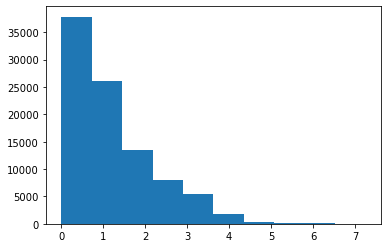

In [69]:
bad_indices = np.isnan(error2)
good_indices = ~bad_indices
good_x = error2[good_indices]
plt.hist(good_x)

(array([3.3145e+04, 2.6357e+04, 1.7093e+04, 1.0150e+04, 4.4310e+03,
        1.5710e+03, 3.5800e+02, 1.6500e+02, 2.6000e+01, 1.0000e+00]),
 array([8.58306885e-06, 8.46661545e-01, 1.69331451e+00, 2.53996747e+00,
        3.38662043e+00, 4.23327339e+00, 5.07992635e+00, 5.92657931e+00,
        6.77323228e+00, 7.61988524e+00, 8.46653820e+00]),
 <BarContainer object of 10 artists>)

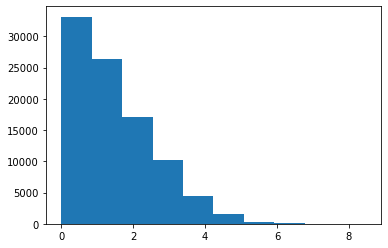

In [70]:
bad_indices = np.isnan(error1)
good_indices = ~bad_indices
good_x = error1[good_indices]
plt.hist(good_x)

In [53]:
error_est = (error1+error2)/2
print(np.nanmean(error_est))

-0.2488201590457351


In [54]:
filename = 'best_rf_model.sav'
pickle.dump(rf_model, open(filename, 'wb'))

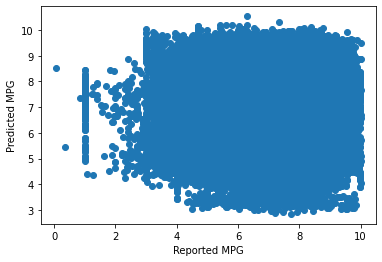

In [55]:
from matplotlib import pyplot as plt

plt.scatter(true_pIC50, ye)
#plt.plot([5, 45], [5, 45], 'k--')
plt.xlabel('Reported MPG')
plt.ylabel('Predicted MPG')
plt.show()

In [120]:
import forestci as fci

fci.calc_inbag(len(X_train), rf_model)
mpg_V_IJ_unbiased = fci.random_forest_error(rf_model, X_train,
                                            X_test, memory_constrained = True,
                                           memory_limit = 100)

In [121]:
x_plot = rf_model.predict(X_test)
yerr=np.sqrt(mpg_V_IJ_unbiased)

In [81]:
print(type(x_plot))
print(type(y_test))
print(type(yerr))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [123]:
yerr

array([17.17566004, 17.17354823, 17.17026987, ..., 17.17093174,
       17.18098396, 17.16387713])

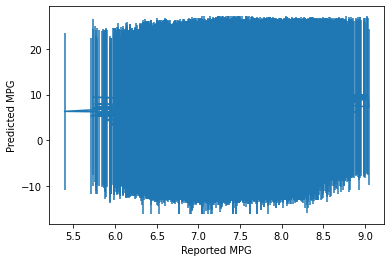

In [122]:
# Plot error bars for predicted MPG using unbiased variance
plt.errorbar(x_plot.astype(np.float), pic50_test.astype(np.float), yerr) #yerr=[err_up, err_down]
#plt.plot([5, 45], [5, 45], 'k--')
plt.xlabel('Reported MPG')
plt.ylabel('Predicted MPG')
plt.show()

In [ ]:
# Plot error bars for predicted MPG using unbiased variance
plt.errorbar(x_plot.astype(np.float), pic50_test.astype(np.float), yerr) #yerr=[err_up, err_down]
#plt.plot([5, 45], [5, 45], 'k--')
plt.xlabel('Reported MPG')
plt.ylabel('Predicted MPG')
plt.show()

In [92]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X[x].reshape(1, -1))[0])
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

In [112]:
err_down, err_up = pred_ints(rf_model, X_test, percentile=95)

In [164]:
correct = 0.
for i in predictions["actual"].index:
    if predictions["lower"][i] <= predictions["actual"][i] <= predictions["upper"][i]:
        correct += 1
print(correct/len(truth))

0.8019712786815749


In [131]:
from sklearn.ensemble import GradientBoostingRegressor
# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9
# Each model has to be separate
lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA, n_estimators = 10)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls", n_estimators = 10)
upper_model = GradientBoostingRegressor(loss="quantile",
                                        alpha=UPPER_ALPHA, n_estimators = 10)

In [139]:
# Fit models
lower_model.fit(X_train, pic50_train)

GradientBoostingRegressor(alpha=0.1, loss='quantile', n_estimators=10)

In [140]:
mid_model.fit(X_train, pic50_train)

GradientBoostingRegressor(n_estimators=10)

In [142]:
upper_model.fit(X_train, pic50_train)

GradientBoostingRegressor(loss='quantile', n_estimators=10)

In [143]:
# Record actual values on test set
predictions = pd.DataFrame(pic50_test)
# Predict

In [144]:
predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

In [152]:
predictions.columns = ['actual','lower','mid','upper']
predictions

,actual,lower,mid,upper
0,7.567031,5.028039,6.979146,8.660341
1,7.251037,4.428586,6.734513,8.471084
2,7.759451,4.905871,6.911438,8.465665
3,8.309804,4.905871,6.911438,8.465665
4,6.623240,4.905871,6.904193,8.465665
...,...,...,...,...
18866,7.454693,5.158600,7.000660,8.441400
18867,6.892451,5.158600,6.915130,8.260393
18868,7.696804,5.158600,6.970782,8.471271
18869,8.602060,5.153856,6.943945,8.611005


In [147]:
def calculate_error(predictions):
    """
    Calculate the absolute error associated with prediction intervals
    
    :param predictions: dataframe of predictions
    :return: None, modifies the prediction dataframe
    
    """
    predictions['absolute_error_lower'] = (predictions['lower'] - predictions["actual"]).abs()
    predictions['absolute_error_upper'] = (predictions['upper'] - predictions["actual"]).abs()
    
    predictions['absolute_error_interval'] = (predictions['absolute_error_lower'] + predictions['absolute_error_upper']) / 2
    predictions['absolute_error_mid'] = (predictions['mid'] - predictions["actual"]).abs()
    
    predictions['in_bounds'] = predictions["actual"].between(left=predictions['lower'], right=predictions['upper'])

In [153]:
calculate_error(predictions)
metrics = predictions[['absolute_error_lower', 'absolute_error_upper', 'absolute_error_interval', 'absolute_error_mid', 'in_bounds']].copy()
metrics.describe()

,absolute_error_lower,absolute_error_upper,absolute_error_interval,absolute_error_mid
count,18871.000000,1.887100e+04,18871.000000,18871.000000
mean,2.056358,1.779561e+00,1.917959,1.081270
std,1.220995,1.314551e+00,0.312736,0.763057
min,0.000008,2.208324e-07,1.451865,0.000044
25%,1.032209,6.666804e-01,1.734638,0.457411
50%,2.067821,1.517488e+00,1.843775,0.965185
75%,3.002779,2.633394e+00,2.000082,1.587836
max,5.694345,7.718717e+00,5.903441,6.074375


In [183]:
#a = pearsonr(pic50_train, mid_model.predict(X_train))
#b = pearsonr(predictions["actual"], predictions["mid"])
test_list = pd.isnull(true_pIC50)
res = [i for i, val in enumerate(test_list) if val] 
true_pIC50 = np.delete(true_pIC50,res,0)
predict2 = np.delete(predict2,res,0)

a = pearsonr(true_pIC50,predict2)
print("Random Forest train r = ",a)
#print("Random Forest test r = ",b)

Random Forest train r =  (0.2621982783397316, 0.0)


In [184]:
predict2

array([7.80670171, 7.76558509, 7.41173172, ..., 6.44735746, 6.55673323,
       6.69063387])

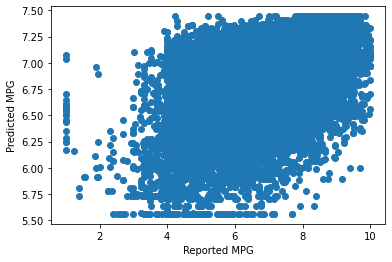

In [160]:
# Plot error bars for predicted MPG using unbiased variance
plt.scatter(predictions["actual"].astype(np.float), predictions["mid"].astype(np.float))#, yerr=[(predictions["upper"]-predictions["mid"]), (predictions["mid"]-predictions["lower"])])
#plt.plot([5, 45], [5, 45], 'k--')
plt.xlabel('Reported MPG')
plt.ylabel('Predicted MPG')
plt.show()

In [185]:
with open('quantiles.pkl', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump([upper_model, mid_model, lower_model], f)

TypeError: write() argument must be str, not bytes

In [128]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from skgarden import RandomForestQuantileRegressor

rfqr = RandomForestQuantileRegressor(n_estimators=10)

In [129]:
y_true_all = []
lower = []
upper = []

rfqr.set_params(max_features=X_train.shape[1] // 3)
rfqr.fit(X_train, y_train)

C:\Users\Julia\anaconda3\envs\multiPurpose\lib\site-packages\sklearn\tree\_classes.py:327: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
C:\Users\Julia\anaconda3\envs\multiPurpose\lib\site-packages\sklearn\tree\_classes.py:327: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
C:\Users\Julia\anaconda3\envs\multiPurpose\lib\site-packages\sklearn\tree\_classes.py:327: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
C:\Users\Julia\anaconda3\envs\multiPurpose\lib\site-packages\sklearn\tree\_classes.py:327: FutureWarning: The parameter 'pre

AttributeError: 'DecisionTreeQuantileRegressor' object has no attribute 'y_train_leaves_'

In [ ]:
y_true_all = np.concatenate((y_true_all, y_test))
upper = np.concatenate((upper, rfqr.predict(X_test, quantile=98.5)))
lower = np.concatenate((lower, rfqr.predict(X_test, quantile=2.5)))

interval = upper - lower
sort_ind = np.argsort(interval)
y_true_all = y_true_all[sort_ind]
upper = upper[sort_ind]
lower = lower[sort_ind]
mean = (upper + lower) / 2

# Center such that the mean of the prediction interval is at 0.0
y_true_all -= mean
upper -= mean
lower -= mean

(array([   7.,    0.,  273., 1678., 2326., 5085., 6269., 2076.,  990.,
         167.]),
 array([2.58448049, 3.19783829, 3.81119609, 4.42455389, 5.03791168,
        5.65126948, 6.26462728, 6.87798508, 7.49134287, 8.10470067,
        8.71805847]),
 <BarContainer object of 10 artists>)

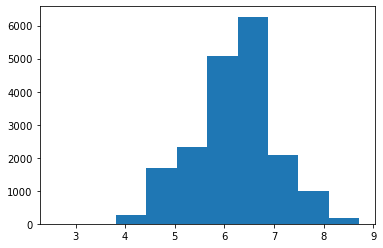

In [111]:
plt.hist(err_down)

In [102]:
np.array(err_up)<8

array([False, False, False, ..., False, False, False])

<AxesSubplot:ylabel='Count'>

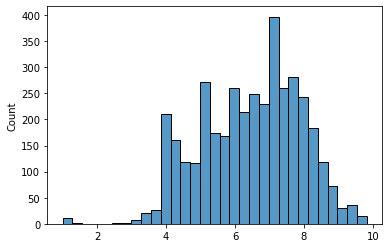

In [108]:
import seaborn as sns
sns.histplot(pic50_test[np.array(err_down)<5])

In [105]:
print(min(y_test[np.array(err_up)<8]))
print(max(y_test[np.array(err_up)<8]))

 0.110
9220


In [ ]:
from DeepPurpose import utils, dataset, CompoundPred
from DeepPurpose import DTI as models

data_path = './data//BindingDB_All.tsv'
X_drugs, X_targets, y = dataset.process_BindingDB(path = data_path, df = None, y = 'IC50', binary = False, convert_to_log = True, threshold = 0)
drug_encoding, target_encoding = 'Morgan', 'Conjoint_triad'
train_all, val, test = utils.data_process(X_drugs, X_targets, y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[1,0,0])

In [ ]:
idxlist = df_want.index
train_true = train_all.iloc[idxlist[idxlist<len(train_all)]]

In [ ]:
from IPython.display import clear_output

y_pred = train_all
y_pred['pred'] = 0
for i in train_true.index:
    print(i)
    clear_output(wait=True)
    try:
        y_pred['pred'].iloc[i:i+1] = model.predict(train_all.loc[i:i+1])
    except:
        y_pred['pred'].iloc[i] = 0